In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p import dis2pvi_cE as dvi
#import biolord
from data.biolord_dev.src import biolord
from scvi.model.base import BaseModelClass

#from scib_metrics.benchmark import Benchmarker

from sklearn.metrics import r2_score

from scDisInFact import scdisinfact, create_scdisinfact_dataset


Global seed set to 0
Global seed set to 0


In [2]:
#from metrics.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

#from scib_metrics.benchmark import Benchmarker


In [3]:
adata = sc.read_h5ad('data/eraslan_preprocessed1200_split.h5ad')
adata_biolord = sc.read_h5ad('data/eraslan_preprocessed1200_split.h5ad')
adata.var.index = adata.var["gene_name"]
#adata_biolord.var.index = adata_biolord.var["gene_name"]


In [4]:
adata.obs["ood_group"] = "train"
ground_truth_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "male")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
control_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "female")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
adata.obs.loc[ground_truth_cells, 'ood_group'] = "gt"
adata.obs.loc[control_cells, 'ood_group'] = "control"
adata.obs["ood_group"].value_counts()


ood_group
train      208512
control       345
gt            268
Name: count, dtype: int64

In [5]:
adata_train = adata[ adata.obs["ood_group"]=="train" ]

In [5]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata


In [6]:
# specify name of dataset 
data_name = 'eraslan'

# specify attributes
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin']

# create numerical index for each attr in cats
create_cats_idx(adata_train, cats)

today = datetime.today().strftime('%Y-%m-%d')
today

'2024-04-16'

In [7]:
# cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']
# pre_path = 'models/dis2p_cE/'
# model_name = 'cf20beta1/'
# # model_name = 'fine_tuned_regLoss_ood/'
# # model_name = 'fine_tuned_regLoss/'
# model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

In [8]:
#Dis2pvi_cE  (Regular loss)
arch_dict = {'n_layers': 2,
 'n_hidden': 1024,
 'n_latent_shared': 40,
 'n_latent_attribute': 40,
 'dropout_rate': 0.2,
}

train_dict = {
 'max_epochs': 2000,
 'batch_size': 512,
 'cf_weight': 2.18,
 'beta': 0.436,
 'clf_weight': 90.12,
 'adv_clf_weight': 1200, #2000 bad, #1500 decent,     #6.87,
 'adv_period': 2,
 'n_cf': 3,
}
plan_kwargs = {
 'lr': 0.0001,
 'weight_decay': 0.000076
}

module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

In [16]:


# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={arch_dict["n_layers"]},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
dvi.Dis2pVI_cE.setup_anndata(
    adata_train,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
dis2p_model = dvi.Dis2pVI_cE(adata_train, n_layers=arch_dict["n_layers"])
dis2p_model.train(**train_dict)
dis2p_model.save(f"{pre_path}/{model_name}")

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys wil

Epoch 1/2000:   0%|                                                                         | 0/2000 [00:00<?, ?it/s]

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 53/2000:   3%| | 53/2000 [17:17<10:35:01, 19.57s/it, v_num=1, loss_validation=2.31e+3, x_0_validation=180, x_1_
Monitored metric loss_validation did not improve in the last 45 records. Best score: 2215.876. Signaling Trainer to stop.


ValueError: models/dis2p_cE/2024-04-15,dis2p_cE,eraslan,n_layers=2,max_epochs=2000,batch_size=512,cf_weight=2.18,beta=0.436,clf_weight=90.12,adv_clf_weight=1200,adv_period=2,n_cf=3 already exists. Please provide another directory for saving.

In [14]:
# Z_0
adata_train.obsm[f'dis2p_cE_Z_0'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata_train.obsm[f'dis2p_cE_Z_{i+1}'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata_train.obsm[f'dis2p_cE_Z_not_{i+1}'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

---UMAP for dis2p_cE_Z_0---


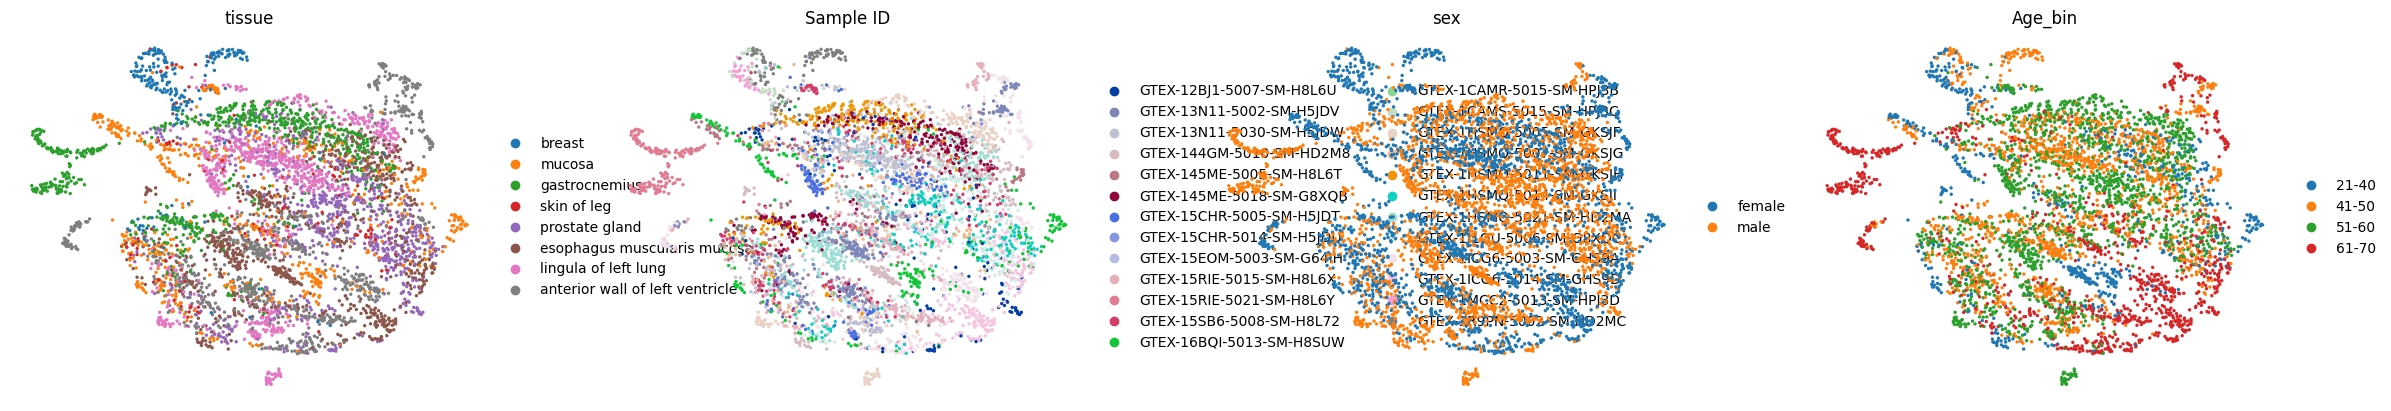

---UMAP for dis2p_cE_Z_1---
tissue


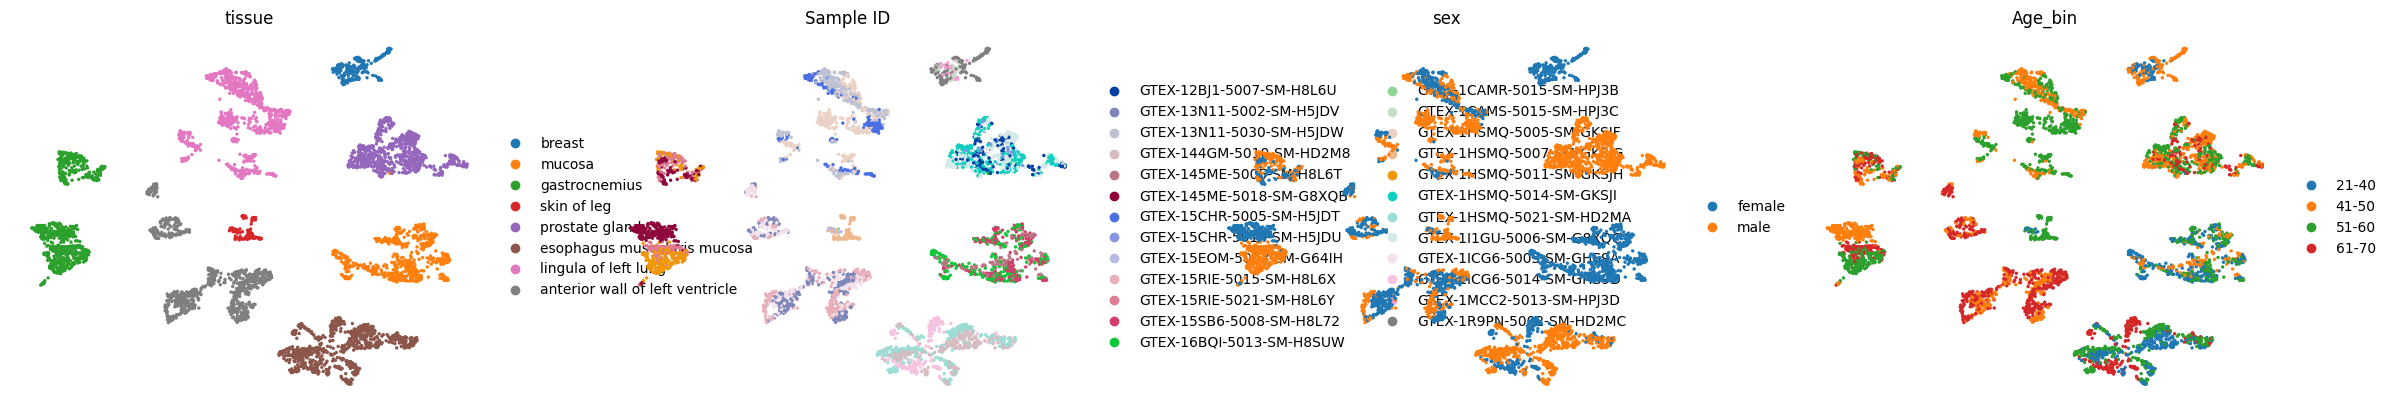

---UMAP for dis2p_cE_Z_2---
Sample ID


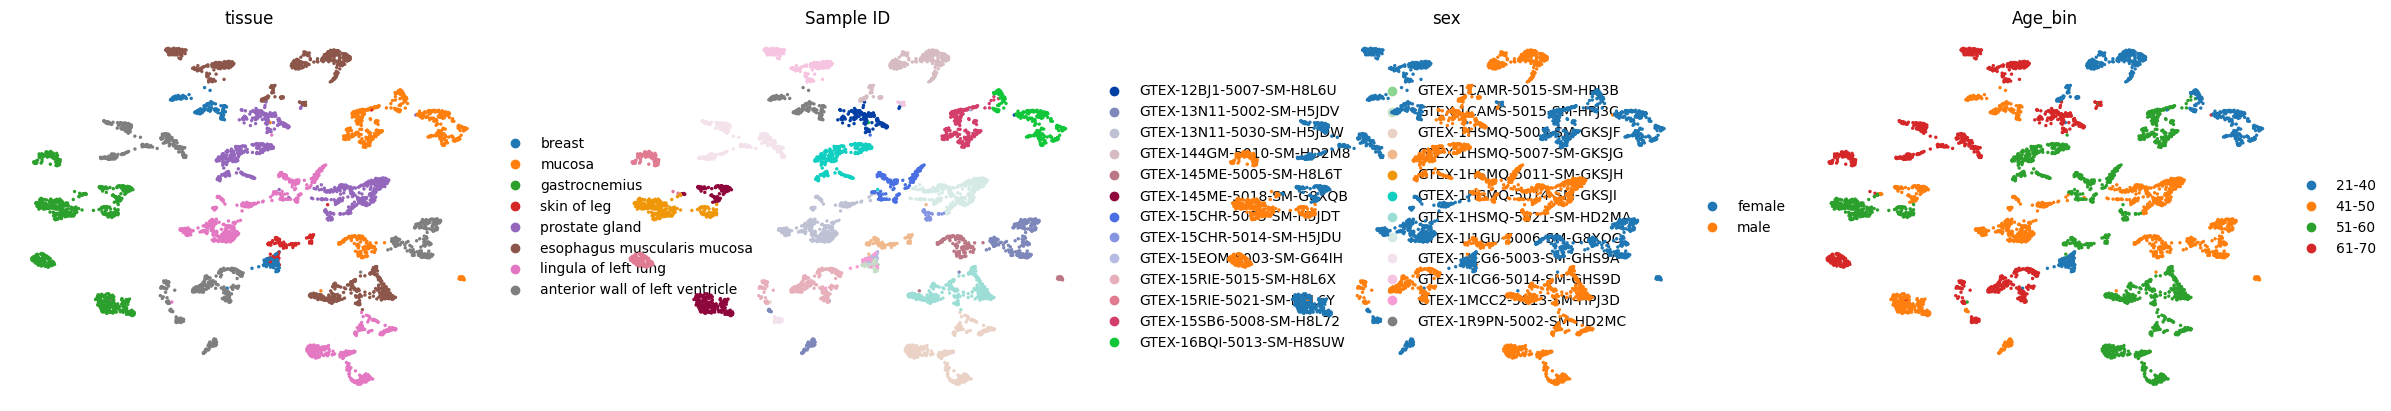

---UMAP for dis2p_cE_Z_3---
sex


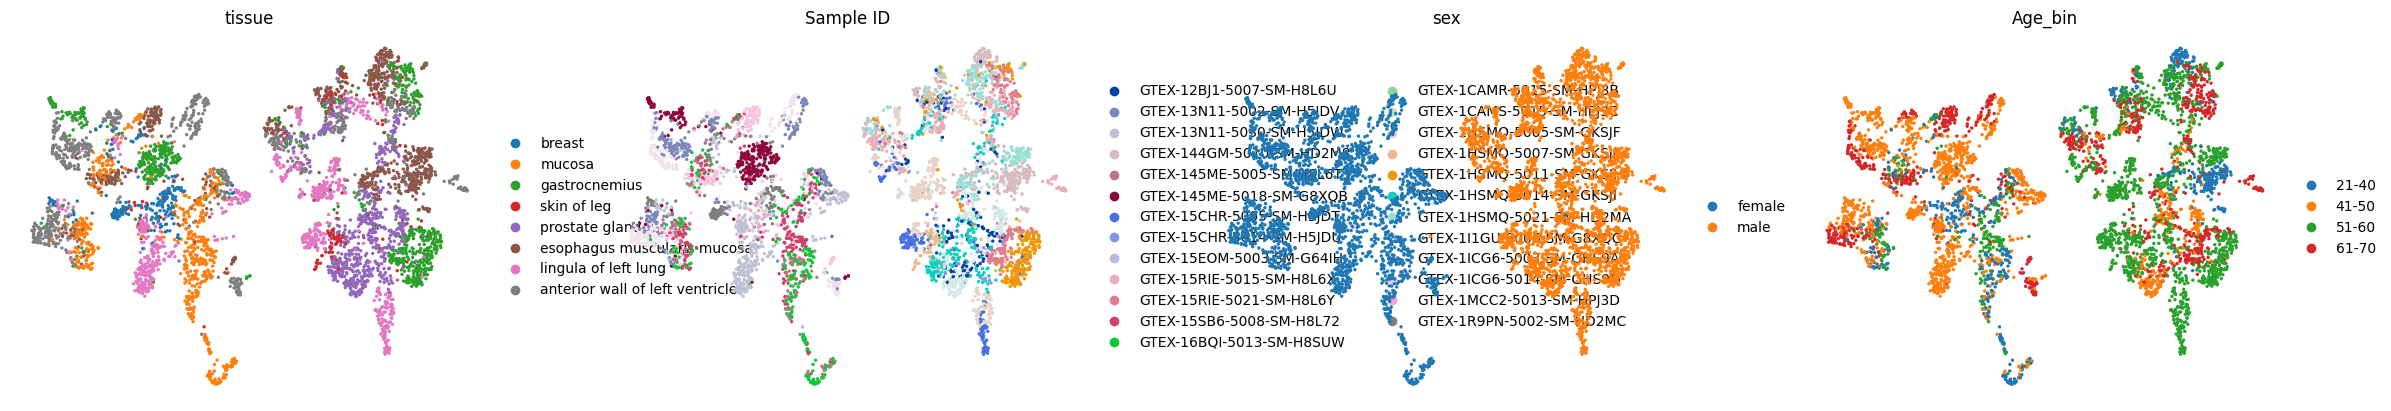

---UMAP for dis2p_cE_Z_4---
Age_bin


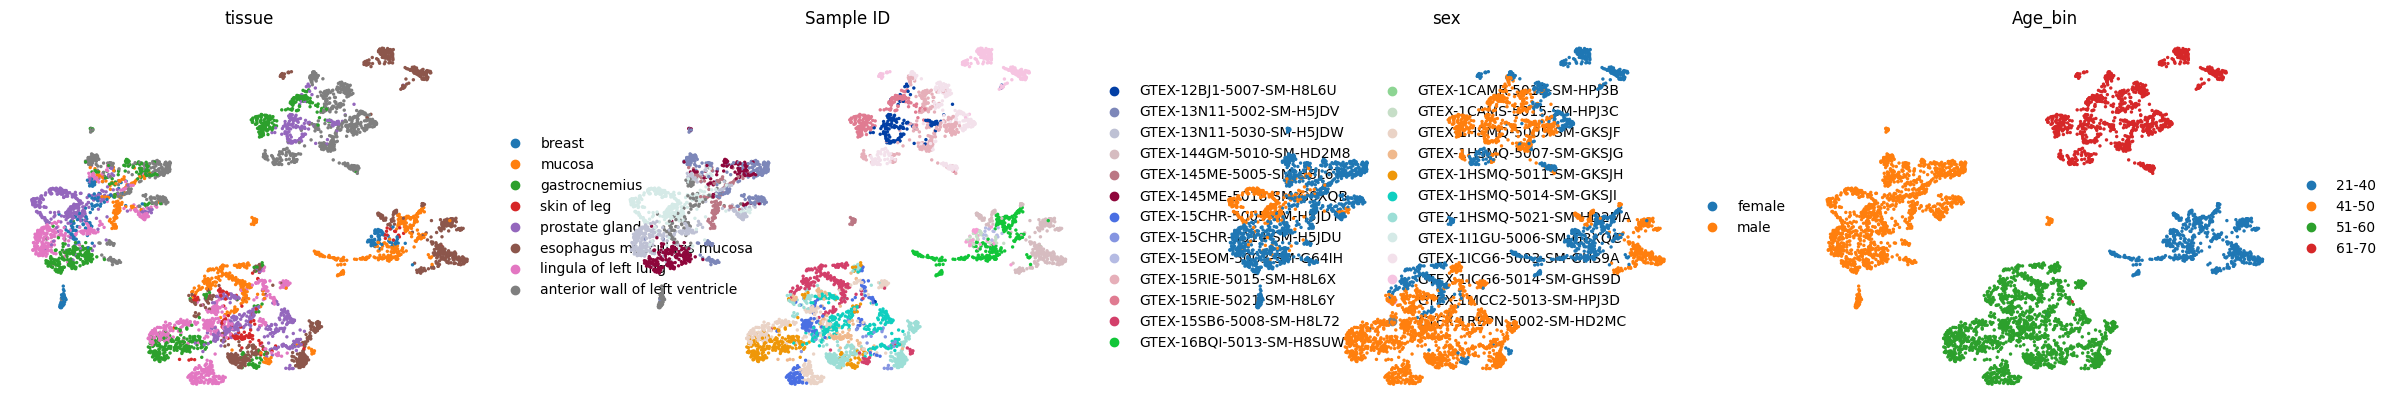

In [15]:
import warnings
warnings.filterwarnings("ignore")
import random
sample = random.sample(range(len(adata_train)), 5000)

nrow = len(cats) + 1
ncol = len(cats)
# fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    adata_ = adata_train[sample]
    sc.pp.neighbors(adata_, use_rep=f"{latent_name}")
    sc.tl.umap(adata_)

    sc.pl.umap(
        adata_,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

---UMAP for dis2p_cE_Z_0---


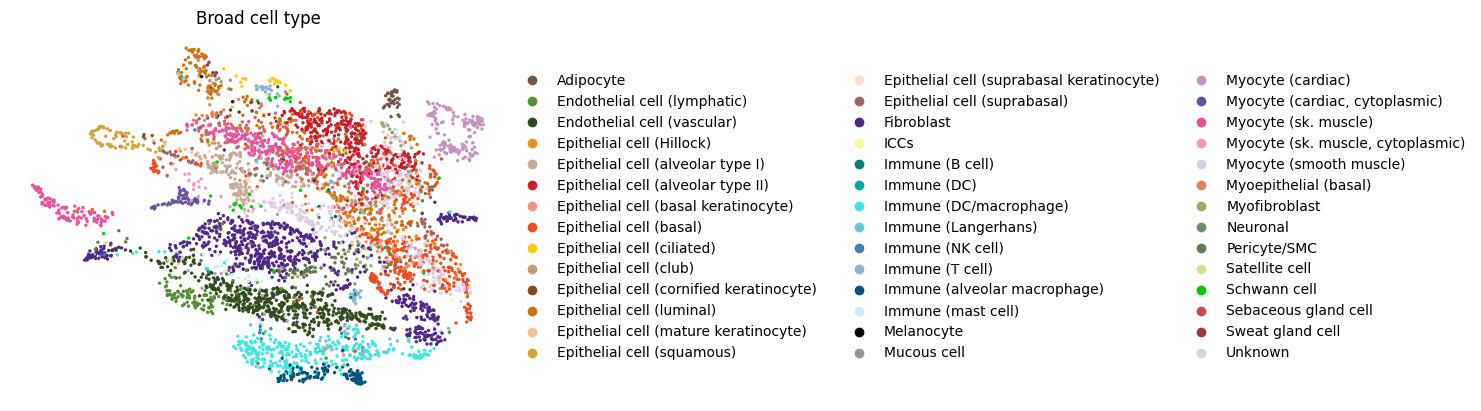

---UMAP for dis2p_cE_Z_1---
tissue


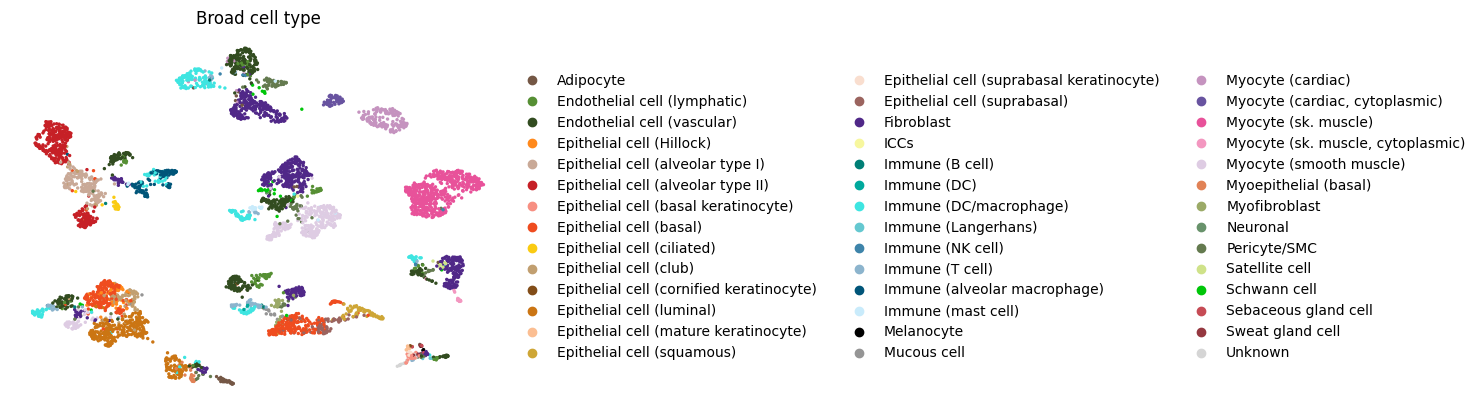

---UMAP for dis2p_cE_Z_2---
Sample ID


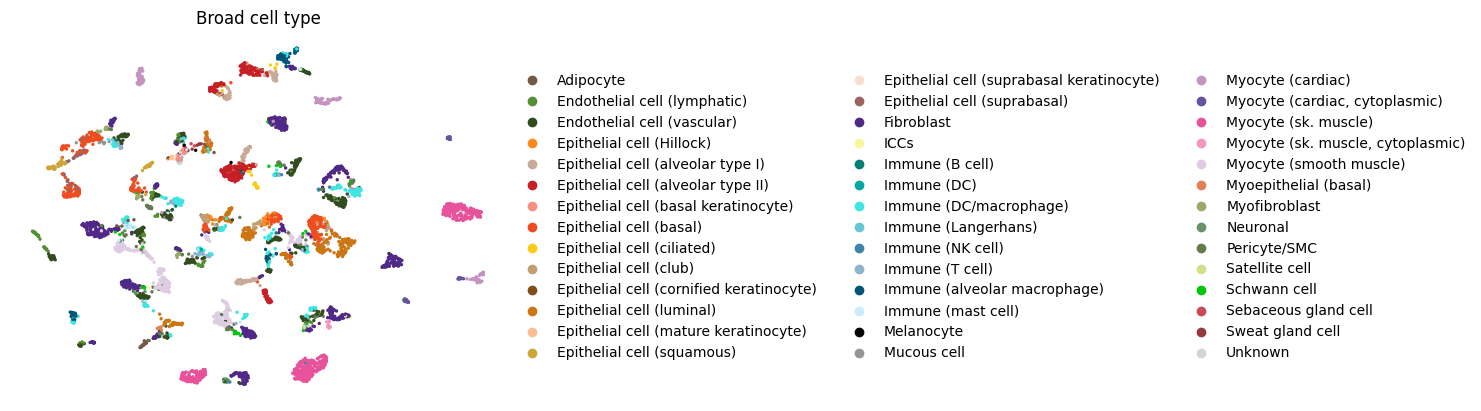

---UMAP for dis2p_cE_Z_3---
sex


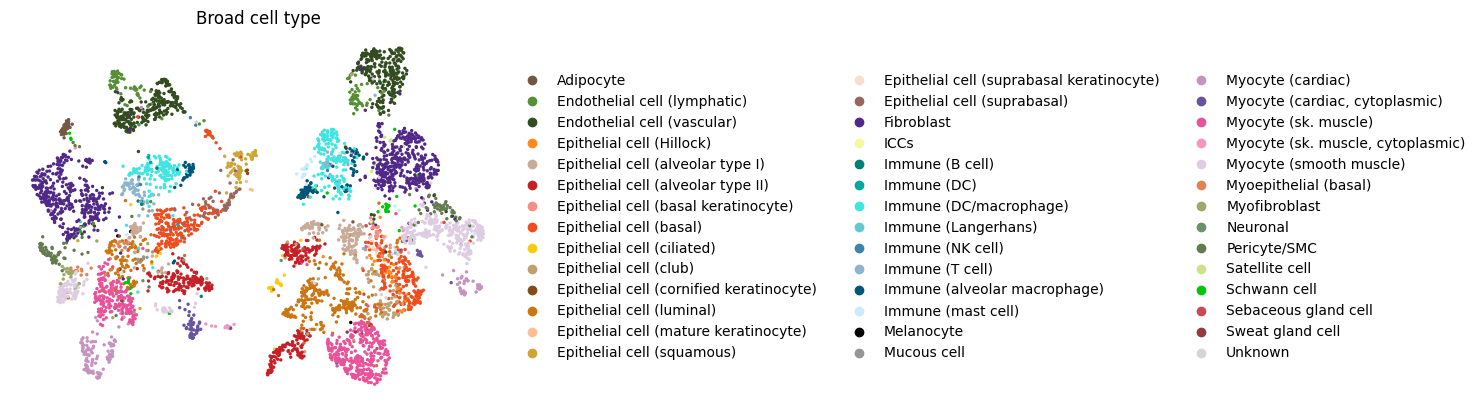

---UMAP for dis2p_cE_Z_4---
Age_bin


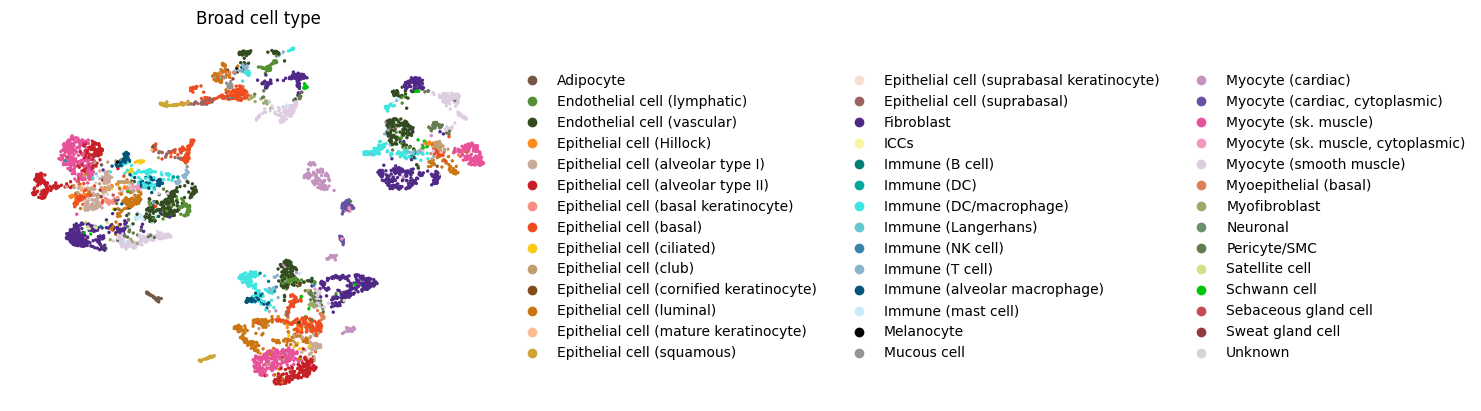

In [19]:
import warnings
warnings.filterwarnings("ignore")
import random
sample = random.sample(range(len(adata_train)), 5000)

nrow = len(cats) + 1
ncol = len(cats)
# fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    adata_ = adata_train[sample]
    sc.pp.neighbors(adata_, use_rep=f"{latent_name}")
    sc.tl.umap(adata_)

    sc.pl.umap(
        adata_,
        color=["Broad cell type"],
        ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

In [35]:
def asw_per_covariate(model,
                      adata,
                      cats,):
    for i in range(len(cats)):
        null_idx = [s for s in range(len(cats)) if s != i]
        # Z_i
        adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)

    results = {}

    for i, label in enumerate(cats):
        results[label] = {}
        results[label]['conservation'] = scib.me.silhouette(adata, label_key=label, embed=f"dis2p_cE_Z_{i+1}")
        batch_scores = []        
        for batch in cats:
            if label == batch:
                continue
            batch_scores.append(scib.me.silhouette(adata, label_key=batch, embed=f"dis2p_cE_Z_{i+1}"))

        results[label]['batch'] = np.mean(batch_scores)
    
    return results

In [37]:
asw_per_covariate(dis2p_model, adata_train, cats)

Epoch 1/400:   0%|                                                                                    | 0/400 [27:30<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import random
sample = random.sample(range(len(adata_train)), 5000)

nrow = len(cats) + 1
ncol = len(cats)
# fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    adata_ = adata_train[sample]
    sc.pp.neighbors(adata_, use_rep="")
    sc.tl.umap(adata_)

    sc.pl.umap(
        adata_,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

In [10]:
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={arch_dict["n_layers"]},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())
dis2p_model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata_train)
# dis2p_model = dvi.Dis2pVI_cE.load("models/dis2p_cE/2024-04-15,dis2p_cE,eraslan,n_layers=2,max_epochs=2000,batch_size=512,cf_weight=2.18,beta=0.436,clf_weight=90.12,adv_clf_weight=1200,adv_period=2,n_cf=3",
#                                  adata=adata_train.copy())

INFO     File                                                                                                      
         models/dis2p_cE/2024-04-15,dis2p_cE,eraslan,n_layers=2,max_epochs=2000,batch_size=512,cf_weight=2.18,beta=
         0.436,clf_weight=90.12,adv_clf_weight=1200,adv_period=2,n_cf=3/model.pt already downloaded                


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


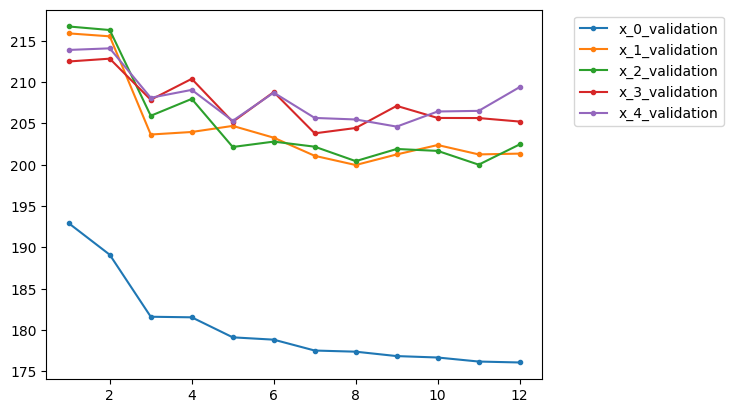

In [20]:
# Assuming you have defined model.history as a dictionary with keys as labels and values as data

for k, v in dis2p_model.history.items():
    if ('x_' in k) and ('validation' in k) and ('rec' not in k):
        plt.plot(range(1, len(v) + 1), v, '.-', label=k)

# Adjust the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Train Biolord

In [59]:
from data.biolord_dev.src import biolord
#import biolord

In [60]:
biolord.Biolord.setup_anndata(
    adata=adata_biolord,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts"
)

In [61]:
# params in these cells are taken from here: https://biolord.readthedocs.io/en/latest/tutorials/biolord_omics.html#instantiate-a-biolord-model
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}
biolord_model = biolord.Biolord(
    adata=adata_biolord,
    n_latent=128,
    model_name="eraslan_biolord_new",
    module_params=module_params,
)

Global seed set to 42


In [62]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
biolord_model.train(
    max_epochs=400,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    enable_checkpointing=False,
    early_stopping_patience=45,
    check_val_every_n_epoch=10,
    num_workers=1,
    #accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|                                                                                    | 0/400 [00:00<?, ?it/s]

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/400:   0%| | 1/400 [00:11<1:18:01, 11.73s/it, v_num=1, val_generative_mean_accuracy=0.591, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 3/400:   0%| | 2/400 [00:23<1:19:12, 11.94s/it, v_num=1, val_generative_mean_accuracy=0.571, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 4/400:   1%| | 3/400 [00:35<1:19:14, 11.98s/it, v_num=1, val_generative_mean_accuracy=0.583, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 5/400:   1%| | 4/400 [00:47<1:19:08, 11.99s/it, v_num=1, val_generative_mean_accuracy=0.626, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 6/400:   1%| | 5/400 [01:00<1:19:41, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.601, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 7/400:   2%| | 6/400 [01:12<1:19:48, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.615, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 8/400:   2%| | 7/400 [01:24<1:19:34, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.632, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 9/400:   2%| | 8/400 [01:36<1:19:22, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.622, val_generative_var_accuracy

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 10/400:   2%| | 9/400 [01:49<1:19:56, 12.27s/it, v_num=1, val_generative_mean_accuracy=0.637, val_generative_var_accurac

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 11/400:   2%| | 10/400 [02:01<1:19:33, 12.24s/it, v_num=1, val_generative_mean_accuracy=0.656, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 12/400:   3%| | 11/400 [02:13<1:19:06, 12.20s/it, v_num=1, val_generative_mean_accuracy=0.659, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 13/400:   3%| | 12/400 [02:25<1:18:50, 12.19s/it, v_num=1, val_generative_mean_accuracy=0.669, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 14/400:   3%| | 13/400 [02:37<1:18:22, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.662, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 15/400:   4%| | 14/400 [02:50<1:18:29, 12.20s/it, v_num=1, val_generative_mean_accuracy=0.668, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 16/400:   4%| | 15/400 [03:02<1:18:27, 12.23s/it, v_num=1, val_generative_mean_accuracy=0.665, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 17/400:   4%| | 16/400 [03:14<1:17:56, 12.18s/it, v_num=1, val_generative_mean_accuracy=0.662, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 18/400:   4%| | 17/400 [03:26<1:17:33, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.649, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 19/400:   4%| | 18/400 [03:38<1:17:08, 12.12s/it, v_num=1, val_generative_mean_accuracy=0.643, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 20/400:   5%| | 19/400 [03:50<1:16:51, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.63, val_generative_var_accurac

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 21/400:   5%| | 20/400 [04:02<1:16:48, 12.13s/it, v_num=1, val_generative_mean_accuracy=0.616, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 22/400:   5%| | 21/400 [04:14<1:16:25, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.632, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 23/400:   6%| | 22/400 [04:27<1:16:24, 12.13s/it, v_num=1, val_generative_mean_accuracy=0.632, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 24/400:   6%| | 23/400 [04:39<1:16:02, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.613, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 25/400:   6%| | 24/400 [04:51<1:16:02, 12.13s/it, v_num=1, val_generative_mean_accuracy=0.616, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 26/400:   6%| | 25/400 [05:03<1:16:16, 12.20s/it, v_num=1, val_generative_mean_accuracy=0.613, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 27/400:   6%| | 26/400 [05:15<1:15:52, 12.17s/it, v_num=1, val_generative_mean_accuracy=0.606, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 28/400:   7%| | 27/400 [05:27<1:15:43, 12.18s/it, v_num=1, val_generative_mean_accuracy=0.616, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 29/400:   7%| | 28/400 [05:40<1:15:19, 12.15s/it, v_num=1, val_generative_mean_accuracy=0.606, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 30/400:   7%| | 29/400 [05:52<1:14:55, 12.12s/it, v_num=1, val_generative_mean_accuracy=0.602, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 31/400:   8%| | 30/400 [06:04<1:14:58, 12.16s/it, v_num=1, val_generative_mean_accuracy=0.592, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 32/400:   8%| | 31/400 [06:16<1:14:33, 12.12s/it, v_num=1, val_generative_mean_accuracy=0.588, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 33/400:   8%| | 32/400 [06:28<1:14:36, 12.16s/it, v_num=1, val_generative_mean_accuracy=0.578, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 34/400:   8%| | 33/400 [06:40<1:14:15, 12.14s/it, v_num=1, val_generative_mean_accuracy=0.587, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 35/400:   8%| | 34/400 [06:53<1:14:22, 12.19s/it, v_num=1, val_generative_mean_accuracy=0.596, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 36/400:   9%| | 35/400 [07:05<1:14:40, 12.27s/it, v_num=1, val_generative_mean_accuracy=0.578, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 37/400:   9%| | 36/400 [07:17<1:14:26, 12.27s/it, v_num=1, val_generative_mean_accuracy=0.576, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 38/400:   9%| | 37/400 [07:29<1:13:40, 12.18s/it, v_num=1, val_generative_mean_accuracy=0.582, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 39/400:  10%| | 38/400 [07:42<1:13:46, 12.23s/it, v_num=1, val_generative_mean_accuracy=0.576, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 40/400:  10%| | 39/400 [07:54<1:13:14, 12.17s/it, v_num=1, val_generative_mean_accuracy=0.593, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 41/400:  10%| | 40/400 [08:06<1:13:10, 12.19s/it, v_num=1, val_generative_mean_accuracy=0.601, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 42/400:  10%| | 41/400 [08:18<1:12:39, 12.14s/it, v_num=1, val_generative_mean_accuracy=0.577, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 43/400:  10%| | 42/400 [08:30<1:12:21, 12.13s/it, v_num=1, val_generative_mean_accuracy=0.584, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 44/400:  11%| | 43/400 [08:42<1:11:58, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.579, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 45/400:  11%| | 44/400 [08:54<1:11:38, 12.07s/it, v_num=1, val_generative_mean_accuracy=0.569, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 46/400:  11%| | 45/400 [09:06<1:11:20, 12.06s/it, v_num=1, val_generative_mean_accuracy=0.571, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 47/400:  12%| | 46/400 [09:18<1:11:24, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.562, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 48/400:  12%| | 47/400 [09:30<1:11:03, 12.08s/it, v_num=1, val_generative_mean_accuracy=0.573, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 49/400:  12%| | 48/400 [09:42<1:10:20, 11.99s/it, v_num=1, val_generative_mean_accuracy=0.559, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 50/400:  12%| | 49/400 [09:54<1:10:12, 12.00s/it, v_num=1, val_generative_mean_accuracy=0.563, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 51/400:  12%|▏| 50/400 [10:06<1:10:00, 12.00s/it, v_num=1, val_generative_mean_accuracy=0.546, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 52/400:  13%|▏| 51/400 [10:18<1:10:25, 12.11s/it, v_num=1, val_generative_mean_accuracy=0.557, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 53/400:  13%|▏| 52/400 [10:31<1:10:39, 12.18s/it, v_num=1, val_generative_mean_accuracy=0.564, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 54/400:  13%|▏| 53/400 [10:43<1:10:41, 12.22s/it, v_num=1, val_generative_mean_accuracy=0.544, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 55/400:  14%|▏| 54/400 [10:55<1:10:12, 12.18s/it, v_num=1, val_generative_mean_accuracy=0.549, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 56/400:  14%|▏| 55/400 [11:07<1:10:07, 12.19s/it, v_num=1, val_generative_mean_accuracy=0.547, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 57/400:  14%|▏| 56/400 [11:20<1:10:07, 12.23s/it, v_num=1, val_generative_mean_accuracy=0.534, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 58/400:  14%|▏| 57/400 [11:32<1:09:35, 12.17s/it, v_num=1, val_generative_mean_accuracy=0.541, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 59/400:  14%|▏| 58/400 [11:44<1:08:56, 12.10s/it, v_num=1, val_generative_mean_accuracy=0.549, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multith

Epoch 59/400:  15%|▏| 59/400 [11:56<1:08:59, 12.14s/it, v_num=1, val_generative_mean_accuracy=0.556, val_generative_var_accura

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Monitored metric val_biolord_metric did not improve in the last 45 records. Best score: 0.449. Signaling Trainer to stop.


In [38]:
today

'2024-04-16'

In [63]:
biolord_model.save(f'models/biolord/biolord_eraslan_{today}')

In [ ]:
biolord_model = biolord.Biolord.load(f'models/biolord/biolord_eraslan_{today}', adata=adata_biolord)

# Train scDisInFact

In [66]:
counts = adata_train.layers['counts']
meta_cells = adata_train.obs
condition_key = ['tissue', 'sex', 'Age_bin']
# condition_key = ['tissue', 'Sample ID', 'cell_type', 'sex', 'Age_bin']


data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = condition_key, batch_key = "Sample ID")


# declare latent dimensions, we have two condition types, so there are three element corresponding to 
# shared-bio factor, unshared-bio factor for condition 1, unshared-bio factor for condition 2
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 2, 2, 2]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4
lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]



Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


In [68]:

# training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scdisinfact_model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
scdisinfact_model.train()

losses = scdisinfact_model.train_model(nepochs = nepochs, recon_loss = "NB")
torch.save(scdisinfact_model.state_dict(), 'models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")

Epoch 0, Validating Loss: 6.4541
	 loss reconstruction: 1.44107
	 loss kl comm: 0.07785
	 loss kl diff: 1.45151
	 loss mmd common: 7.27975
	 loss mmd diff: 26.75925
	 loss classification: 4.43549
	 loss group lasso diff: 0.55958
GPU memory usage: 338.237793MB
Epoch 10, Validating Loss: 5.3547
	 loss reconstruction: 1.11955
	 loss kl comm: 0.33860
	 loss kl diff: 3.28782
	 loss mmd common: 10.19245
	 loss mmd diff: 95.61138
	 loss classification: 3.67675
	 loss group lasso diff: 0.51496
GPU memory usage: 339.068359MB
Epoch 20, Validating Loss: 4.4434
	 loss reconstruction: 0.67561
	 loss kl comm: 4.23027
	 loss kl diff: 6.96350
	 loss mmd common: 28.74453
	 loss mmd diff: 121.29287
	 loss classification: 3.19921
	 loss group lasso diff: 0.48392
GPU memory usage: 224.309082MB
Epoch 30, Validating Loss: 4.0770
	 loss reconstruction: 0.59489
	 loss kl comm: 3.35947
	 loss kl diff: 9.89536
	 loss mmd common: 16.20396
	 loss mmd diff: 117.03426
	 loss classification: 2.90848
	 loss group las

In [69]:
torch.save(scdisinfact_model.state_dict(), 'models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")

In [70]:
scdisinfact_model = torch.load('models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")


# SCIB analysis

In [ ]:
for i, c in enumerate(cats):
    nullify_attribute = [cat for cat in cats if cat != c]
    _, latent_adata = model.get_latent_representation_adata(adata=adata, nullify_attribute=nullify_attribute)
    adata.obsm[f"biolord_{i+1}"] = latent_adata.X
    
adata.obsm[f"biolord"] = adata.obsm[f"biolord_3"]

# DEG genes

In [141]:
# adata.obs["ood_group"] = "train"
# ground_truth_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "male")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
# control_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "female")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
# adata.obs.loc[ground_truth_cells, 'ood_group'] = "gt"
# adata.obs.loc[control_cells, 'ood_group'] = "control"
# adata.obs["ood_group"].value_counts()

ood_group
train      208512
control       345
gt            268
Name: count, dtype: int64

In [11]:
adata_ood = adata[ adata.obs["ood_group"]!="train" ]
adata_ood

View of AnnData object with n_obs × n_vars = 613 × 1200
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'deve

In [12]:
sc.pp.normalize_total(adata_ood, layer="counts")
#sc.pp.log1p(adata_ood, layer="counts")


In [13]:
sc.tl.rank_genes_groups(adata_ood, groupby='ood_group', layer="counts", use_raw=False, key_added='ood_DEG')

In [14]:
deg_list = [ j for i in adata_ood.uns["ood_DEG"]["names"] for j in i ] 
deg_list = deg_list[:int(len(deg_list)/2)]
deg_list[:10]


['SAMSN1',
 'LINC00486',
 'THEMIS',
 'RP11-108E14.1',
 'TMSB4X',
 'NGB',
 'SRGN',
 'MT-ND1',
 'RBPJ',
 'MT-ND3']

# CF analysis

### dis2p

In [61]:
adata.obs['idx'] = [i for i in range(len(adata))]

true_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'male') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
source_sub_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'female') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
train_sub_idx = list(adata[(adata.obs['split'] == 'train')].obs.idx)

cats = ['tissue', 'Sample ID', 'sex', 'Age_bin']
cov_idx = 2
cov_value = 'female'
cov_value_cf = 'male'

In [62]:
adata

AnnData object with n_obs × n_vars = 209125 × 1200
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'developme

In [63]:
adata_sub = adata[train_sub_idx]
source_adata = adata[source_sub_idx]


In [64]:
from typing import NamedTuple


class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()


In [65]:
adata_cf = source_adata.copy()
# print(adata_cf)
cov_name = cats[cov_idx]
print(cov_name)
adata_cf.obs[cov_name] = pd.Categorical([cov_value_cf for _ in adata_cf.obs[cov_name]])
batch_size=512
device='cuda'
dvi.Dis2pVI_cE.setup_anndata(
    adata_cf,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)

adata_cf = dis2p_model._validate_anndata(adata_cf)

scdl = dis2p_model._make_data_loader(
    adata=adata_cf, batch_size=batch_size
)

px_cf_mean_list = []

num_samples = 200

i = 0
for tensors in scdl:
    print(i)
    i += 1
    px_cf = dis2p_model.module.sub_forward(idx=cov_idx + 1, x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                                    cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

    # px_cf_mean_list.append(px_cf.sample())
    # px_cf_mean_list.append(px_cf.mean)
    samples = []
    for j in range(num_samples):
        samples.append(px_cf.sample().to('cpu'))
    samples = torch.stack(samples, dim=0)
    px_cf = torch.mean(samples, dim=0)
    px_cf_mean_list.append(px_cf)

sex
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
0


In [66]:
px_cf_mean_tensor = torch.cat(px_cf_mean_list, dim=0)
px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)

px_cf_variance = torch.sub(px_cf_mean_tensor, px_cf_mean_pred)
px_cf_variance = torch.pow(px_cf_variance, 2)
px_cf_variance_pred = torch.mean(px_cf_variance, dim=0)

px_cf_mean_pred, px_cf_variance_pred = px_cf_mean_pred.to('cpu'), px_cf_variance_pred.to('cpu')
px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').numpy()

px_cf_mean_tensor = ad.AnnData(px_cf_mean_tensor)

In [67]:
for tensors in scdl:
    print(tensors[REGISTRY_KEYS.CAT_COVS_KEY])
    break

tensor([[6., 2., 1., 1.],
        [6., 2., 1., 1.],
        [6., 2., 1., 1.],
        ...,
        [6., 2., 1., 1.],
        [6., 2., 1., 1.],
        [6., 2., 1., 1.]])


### dis2p with z0

In [68]:
from scvi.distributions import NegativeBinomial, Poisson, ZeroInflatedNegativeBinomial

adata_cf_2 = source_adata.copy()
    
batch_size=512
dvi.Dis2pVI_cE.setup_anndata(
    adata_cf_2,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
adata_cf_2 = dis2p_model._validate_anndata(adata_cf2)
scdl2 = dis2p_model._make_data_loader(
    adata=adata_cf_2, batch_size=batch_size
)

x_cf_mean_list = []

num_samples = 200

for tensors2, tensors1 in zip(scdl2, scdl):
    # print(tensors1[REGISTRY_KEYS.CAT_COVS_KEY])
    # print(tensors2[REGISTRY_KEYS.CAT_COVS_KEY])

    # use the actual covariates, ie from tensors2, for encoding
    x_= tensors[REGISTRY_KEYS.X_KEY].to(device)
    
    cat_in = torch.split(tensors2[REGISTRY_KEYS.CAT_COVS_KEY].to(device), 1, dim=1)

    emb2 = []
    for i, embedding in enumerate(tensors2[REGISTRY_KEYS.CAT_COVS_KEY].t().to(device)):
        emb2.append(dis2p_model.module.covars_embeddings[str(i)](embedding.long()))
    prior_emb_in = emb2[:]
    emb2 = torch.stack(emb2, dim=0)
    emb2 = torch.permute(emb2, (1, 0, 2))
    emb2 = dis2p_model.module.pert_encoder(emb2).to(device)
    emb2 = emb2.reshape(emb2.shape[0], -1)
    
    print(f"x shape is {x_.shape}")

    qz, z = dis2p_model.module.z_encoders_list[0](torch.hstack((x_, emb2)) )
    library = torch.log(x_.sum(1)).unsqueeze(1)


    
    # use the counterfactual covariates, ie from tensors1, for decoding
    dec_cats = tensors1[REGISTRY_KEYS.CAT_COVS_KEY].to(device)
    
    x_decoder = dis2p_model.module.x_decoders_list[0].to(device)   
    emb = []
    for i, embedding in enumerate(dec_cats.t().to(device)):
        emb.append(dis2p_model.module.covars_embeddings[str(i)](embedding.long()))
    prior_emb_in = emb[:]
    emb = torch.stack(emb, dim=0)
    emb = torch.permute(emb, (1, 0, 2))
    emb = dis2p_model.module.pert_encoder(emb).to(device)
    emb = emb.reshape(emb.shape[0], -1)
    
    print(f"shape of z is {z.shape} ")
    print(f"shape of emb is {emb.shape} ")
    print(f"shape of hstack is {torch.hstack((z,emb)).shape} ")
    px_scale, px_r, px_rate, px_dropout = x_decoder(
        "gene",
        torch.hstack((z,emb)),
        library,
        *dec_cats
    )
    px_r = torch.exp(dis2p_model.module.px_r)
    
    if dis2p_model.module.gene_likelihood == "zinb":
        px_cf = ZeroInflatedNegativeBinomial(
            mu=px_rate,
            theta=px_r,
            zi_logits=px_dropout,
            scale=px_scale,
        )
    elif dis2p_model.module.gene_likelihood == "nb":
        px_cf = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
    elif dis2p_model.module.gene_likelihood == "poisson":
        px_cf = Poisson(px_rate, scale=px_scale)

    samples = []
    for j in range(num_samples):
        samples.append(px_cf.sample().to('cpu'))
    samples = torch.stack(samples, dim=0)
    px_cf = torch.mean(samples, dim=0)
    px_cf_mean_list.append(px_cf)
    


x shape is torch.Size([345, 1200])
shape of z is torch.Size([345, 10]) 
shape of emb is torch.Size([345, 40]) 
shape of hstack is torch.Size([345, 50]) 


In [69]:
px_cf_mean_tensor_z0 = torch.cat(px_cf_mean_list, dim=0)
px_cf_mean_pred_z0 = torch.mean(px_cf_mean_tensor_z0, dim=0)

px_cf_variance_z0 = torch.sub(px_cf_mean_tensor_z0, px_cf_mean_pred_z0)
px_cf_variance_z0 = torch.pow(px_cf_variance_z0, 2)
px_cf_variance_pred_z0 = torch.mean(px_cf_variance_z0, dim=0)

px_cf_mean_pred_z0, px_cf_variance_pred_z0 = px_cf_mean_pred_z0.to('cpu'), px_cf_variance_pred_z0.to('cpu')
px_cf_mean_tensor_z0 = px_cf_mean_tensor_z0.to('cpu').numpy()

px_cf_mean_tensor_z0 = ad.AnnData(px_cf_mean_tensor_z0)

In [105]:
# adata_cf = source_adata.copy()
# cov_name = cats[cov_idx]
# adata_cf.obs[cov_name] = pd.Categorical([cov_value_cf for _ in adata_cf.obs[cov_name]])
# batch_size=512
# device='cuda'
# dvi.Dis2pVI_cE.setup_anndata(
#     adata_cf,
#     layer='counts',
#     categorical_covariate_keys=cats,
#     continuous_covariate_keys=[]
# )

# adata_cf = dis2p_model._validate_anndata(adata_cf)

# scdl = dis2p_model._make_data_loader(
#     adata=adata_cf, batch_size=batch_size
# )

# px_cf_mean_list = []

# num_samples = 200

# i = 0
# for tensors in scdl:
#     print(i)
#     i += 1
#     px_cf = dis2p_model.module.sub_forward(idx=cov_idx + 1, x=tensors[REGISTRY_KEYS.X_KEY].to(device),
#                                     cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

#     # px_cf_mean_list.append(px_cf.sample())
#     # px_cf_mean_list.append(px_cf.mean)
#     samples = []
#     for j in range(num_samples):
#         samples.append(px_cf.sample().to('cpu'))
#     samples = torch.stack(samples, dim=0)
#     px_cf = torch.mean(samples, dim=0)
#     px_cf_mean_list.append(px_cf)

### biolord

In [39]:
#biolord_model = biolord.Biolord.load(f'models/biolord/biolord_eraslan_2024-04-16', adata=adata_biolord)

INFO     File models/biolord/biolord_eraslan_2024-04-16/model.pt already downloaded                                


Global seed set to 42


In [40]:
source_sub_idx = list(adata_biolord[(adata_biolord.obs['split'] == 'test') & (adata_biolord.obs['sex'] == 'female') & (adata_biolord.obs['tissue'] == 'lingula of left lung')].obs.index)
source_adata_biolord = adata_biolord[source_sub_idx].copy()


In [41]:
source_adata_biolord

AnnData object with n_obs × n_vars = 345 × 1200
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'development_

In [42]:
adata_biolord.obs.loc[['CST03_AACGTTGAGATAGTCA-lung', 'CST03_GCTTGAAGTCATCCCT-lung',
       'CST03_ACACCCTGTGATGATA-lung', 'CST03_GCAGCCACACTGTGTA-lung'],:]

Sample ID_prep  \
Unnamed: 0                                                  
CST03_AACGTTGAGATAGTCA-lung  GTEX_13N11_5030_SM_H5JDW_CST   
CST03_GCTTGAAGTCATCCCT-lung  GTEX_13N11_5030_SM_H5JDW_CST   
CST03_ACACCCTGTGATGATA-lung  GTEX_13N11_5030_SM_H5JDW_CST   
CST03_GCAGCCACACTGTGTA-lung  GTEX_13N11_5030_SM_H5JDW_CST   

                            assay_ontology_term_id cell_type_ontology_term_id  \
Unnamed: 0                                                                      
CST03_AACGTTGAGATAGTCA-lung            EFO:0009899                 CL:0000097   
CST03_GCTTGAAGTCATCCCT-lung            EFO:0009899                 CL:0000183   
CST03_ACACCCTGTGATGATA-lung            EFO:0009899                 CL:0000084   
CST03_GCAGCCACACTGTGTA-lung            EFO:0009899                 CL:0000084   

                            disease_ontology_term_id  \
Unnamed: 0                                             
CST03_AACGTTGAGATAGTCA-lung             PATO:0000461   
CST03_GCTTGAAGTCATCCCT-lung             PATO:0000461   
CST03_ACACCCTGTGATGATA-lung             PATO:0000461   
CST03_GCAGCCACACTGTGTA-lung             PATO:0000461   

                            self_reported_ethnicity_ontology_term_id  \
Unnamed: 0                                                             
CST03_AACGTTGAGATAGTCA-lung                                  unknown   
CST03_GCTTGAAGTCATCCCT-lung                                  unknown   
CST03_ACACCCTGTGATGATA-lung                                  unknown   
CST03_GCAGCCACACTGTGTA-lung                                  unknown   

                             is_primary_data organism_ontology_term_id  \
Unnamed: 0                                                               
CST03_AACGTTGAGATAGTCA-lung             True            NCBITaxon:9606   
CST03_GCTTGAAGTCATCCCT-lung             True            NCBITaxon:9606   
CST03_ACACCCTGTGATGATA-lung             True            NCBITaxon:9606   
CST03_GCAGCCACACTGTGTA-lung             True            NCBITaxon:9606   

                            sex_ontology_term_id tissue_ontology_term_id  \
Unnamed: 0                                                                 
CST03_AACGTTGAGATAGTCA-lung         PATO:0000383          UBERON:0008954   
CST03_GCTTGAAGTCATCCCT-lung         PATO:0000383          UBERON:0008954   
CST03_ACACCCTGTGATGATA-lung         PATO:0000383          UBERON:0008954   
CST03_GCAGCCACACTGTGTA-lung         PATO:0000383          UBERON:0008954   

                             n_genes  ...  Sample ID_idx cell_type_idx  \
Unnamed: 0                            ...                                
CST03_AACGTTGAGATAGTCA-lung     1109  ...             22            36   
CST03_GCTTGAAGTCATCCCT-lung      726  ...             22            52   
CST03_ACACCCTGTGATGATA-lung      761  ...             22            30   
CST03_GCAGCCACACTGTGTA-lung      737  ...             22            30   

                             sex_idx  Age_bin_idx  split  _indices  \
Unnamed: 0                                                           
CST03_AACGTTGAGATAGTCA-lung        1            2   test    160231   
CST03_GCTTGAAGTCATCCCT-lung        1            2   test    161212   
CST03_ACACCCTGTGATGATA-lung        1            2   test    161263   
CST03_GCAGCCACACTGTGTA-lung        1            2   test    161367   

                             _scvi_tissue _scvi_Sample ID _scvi_sex  \
Unnamed: 0                                                            
CST03_AACGTTGAGATAGTCA-lung             6               2         0   
CST03_GCTTGAAGTCATCCCT-lung             6               2         0   
CST03_ACACCCTGTGATGATA-lung             6               2         0   
CST03_GCAGCCACACTGTGTA-lung             6               2         0   

                            _scvi_Age_bin  
Unnamed: 0                                 
CST03_AACGTTGAGATAGTCA-lung             1  
CST03_GCTTGAAGTCATCCCT-lung             1  
CST03_ACACCCTGTGATGATA-lung             1  
CST0

In [43]:
biolord_preds = biolord_model.compute_prediction_adata(adata_biolord, adata_source=source_adata_biolord, target_attributes=['sex'])
print(biolord_preds)
biolord_preds = biolord_preds[biolord_preds.obs['sex'] == 'male']
biolord_preds_tensor = torch.tensor(biolord_preds.X)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:01,  1.83s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:05,  2.78s/it]

AnnData object with n_obs × n_vars = 690 × 1200
    obs: 'sex'



/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env_17/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


### Prediction by random sampling from male

In [44]:
# Random sampling from dataset
adata_for_sample = adata[adata.obs['sex'] == 'male']
sample_ids = random.sample(range(len(adata_for_sample)), num_samples)
sampled_adata = adata_for_sample[sample_ids].copy()

### Prediction by scDisInFact

In [121]:
meta_cells

Sample ID_prep  \
Unnamed: 0                                                            
CST01_TAGGCATGTAAATACG-skeletalmuscle  GTEX_1HSMQ_5011_SM_GKSJH_CST   
CST01_CCTTACGTCCGTCAAA-skeletalmuscle  GTEX_1HSMQ_5011_SM_GKSJH_CST   
CST01_CACACTCCATGGAATA-skeletalmuscle  GTEX_1HSMQ_5011_SM_GKSJH_CST   
CST01_CCACTACGTGCAACGA-skeletalmuscle  GTEX_1HSMQ_5011_SM_GKSJH_CST   
CST01_GCAGTTAAGACTGTAA-skeletalmuscle  GTEX_1HSMQ_5011_SM_GKSJH_CST   
...                                                             ...   
TST03_TCGGTAAGTTGGGACA-skin            GTEX_15EOM_5003_SM_G64IH_TST   
TST03_AGGGTGACAAGAAGAG-skin            GTEX_15EOM_5003_SM_G64IH_TST   
TST03_GGGACCTCAAGTCTGT-skin            GTEX_15EOM_5003_SM_G64IH_TST   
TST03_CACAGGCGTACATCCA-skin            GTEX_15EOM_5003_SM_G64IH_TST   
TST03_GACCAATTCCAGTATG-skin            GTEX_15EOM_5003_SM_G64IH_TST   

                                      assay_ontology_term_id  \
Unnamed: 0                                                     
CST01_TAGGCATGTAAATACG-skeletalmuscle            EFO:0009899   
CST01_CCTTACGTCCGTCAAA-skeletalmuscle            EFO:0009899   
CST01_CACACTCCATGGAATA-skeletalmuscle            EFO:0009899   
CST01_CCACTACGTGCAACGA-skeletalmuscle            EFO:0009899   
CST01_GCAGTTAAGACTGTAA-skeletalmuscle            EFO:0009899   
...                                                      ...   
TST03_TCGGTAAGTTGGGACA-skin                      EFO:0009899   
TST03_AGGGTGACAAGAAGAG-skin                      EFO:0009899   
TST03_GGGACCTCAAGTCTGT-skin                      EFO:0009899   
TST03_CACAGGCGTACATCCA-skin                      EFO:0009899   
TST03_GACCAATTCCAGTATG-skin                      EFO:0009899   

                                      cell_type_ontology_term_id  \
Unnamed: 0                                                         
CST01_TAGGCATGTAAATACG-skeletalmuscle                 CL:0000189   
CST01_CCTTACGTCCGTCAAA-skeletalmuscle                 CL:0000189   
CST01_CACACTCCATGGAATA-skeletalmuscle                 CL:0008002   
CST01_CCACTACGTGCAACGA-skeletalmuscle                 CL:0002139   
CST01_GCAGTTAAGACTGTAA-skeletalmuscle                 CL:0002139   
...                                                          ...   
TST03_TCGGTAAGTTGGGACA-skin                           CL:0000362   
TST03_AGGGTGACAAGAAGAG-skin                           CL:0000362   
TST03_GGGACCTCAAGTCTGT-skin                           CL:0000362   
TST03_CACAGGCGTACATCCA-skin                           CL:0000362   
TST03_GACCAATTCCAGTATG-skin                           CL:0000362   

                                      disease_ontology_term_id  \
Unnamed: 0                                                       
CST01_TAGGCATGTAAATACG-skeletalmuscle             PATO:0000461   
CST01_CCTTACGTCCGTCAAA-skeletalmuscle             PATO:0000461   
CST01_CACACTCCATGGAATA-skeletalmuscle             PATO:0000461   
CST01_CCACTACGTGCAACGA-skeletalmuscle             PATO:0000461   
CST01_GCAGTTAAGACTGTAA-skeletalmuscle             PATO:0000461   
...                                                        ...   
TST03_TCGGTAAGTTGGGACA-skin                       PATO:0000461   
TST03_AGGGTGACAAGAAGAG-skin                       PATO:0000461   
TST03_GGGACCTCAAGTCTGT-skin                       PATO:0000461   
TST03_CACAGGCGTACATCCA-skin                       PATO:0000461   
TST03_GACCAATTCCAGTATG-skin                       PATO:0000461   

                                      self_reported_ethnicity_ontology_term_id  \
Unnamed: 0                                                                       
CST01_TAGGCATGTAAATACG-skeletalmuscle                                  unknown   
CST01_CCTTACGTCCGTCAAA-skeletalmuscle                                  unknown   
CST01_CACACTCCATGGAATA-skeletalmuscle                                  unknown   
CST01_CCACTACGTGCAACGA-skeletalmuscle                                  unknown   
CST01_GCAGTTAAGACTGTAA-skeletalmuscle                       

In [ ]:
input_idx = ((meta_cells["tissue_idx"] == "stim") & (meta_cells["Sample ID_idx"] == "severe") & (meta_cells["sex_idx"] == 1)).values
counts_input = counts[input_idx,:].toarray()
meta_input = meta_cells.loc[input_idx,:]

counts_predict = model.predict_counts(input_counts = counts_input, meta_cells = meta_input, condition_keys = ["condition 1", "condition 2"], 
                                      batch_key = "batch", predict_conds = ["ctrl", "healthy"], predict_batch = 0)

In [ ]:
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin']


### Compare

In [70]:
source_adata_cf = adata[source_sub_idx].copy()
source_adata_true = adata[true_idx].copy()

true_x_count = torch.tensor(source_adata_true.X.toarray())
cf_x_count = torch.tensor(source_adata_cf.X.toarray())
random_x_count = torch.tensor(sampled_adata.X.toarray())

sc.pp.normalize_total(px_cf_mean_tensor)
px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)
sc.pp.normalize_total(px_cf_mean_tensor_z0)
px_cf_mean_tensor_z0 = torch.tensor(px_cf_mean_tensor_z0.X)

x_true = true_x_count
x_pred = px_cf_mean_tensor
x_pred_z0 = px_cf_mean_tensor_z0
x_ctrl = cf_x_count
x_random = random_x_count
x_biolord = biolord_preds_tensor

x_true = np.log1p(x_true)
x_pred = np.log1p(x_pred)
x_pred_z0 = np.log1p(x_pred_z0)
x_ctrl = np.log1p(x_ctrl)
x_random = np.log1p(x_random)
x_biolord = np.log1p(x_biolord)

In [74]:
r2_results = {}
r2_var_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_pred_deg_z0 = x_pred_z0[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_random_deg = x_random[:, degs]
    x_biolord_deg = x_biolord[:, degs]

    r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_deg_z0 = r2_score(x_true_deg.mean(0), x_pred_deg_z0.mean(0))
    r2_mean_base_deg = r2_score(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_random_deg = r2_score(x_true_deg.mean(0), x_random_deg.mean(0))
    r2_mean_biolord_deg = r2_score(x_true_deg.mean(0), x_biolord_deg.mean(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Prediction'] = r2_mean_deg
    r2_results[str(n_top_deg)]['Prediction z0'] = r2_mean_deg_z0
    r2_results[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg
    r2_results[str(n_top_deg)]['Random'] = r2_mean_random_deg

    r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))
    r2_var_deg_z0 = r2_score(x_true_deg.var(0), x_pred_deg_z0.var(0))
    r2_var_base_deg = r2_score(x_true_deg.var(0), x_ctrl_deg.var(0))
    r2_var_random_deg = r2_score(x_true_deg.var(0), x_random_deg.var(0))
    r2_var_biolord_deg = r2_score(x_true_deg.var(0), x_biolord_deg.var(0))
    
    r2_var_results[str(n_top_deg)] = {}
    r2_var_results[str(n_top_deg)]['Prediction'] = r2_var_deg
    r2_var_results[str(n_top_deg)]['Prediction z0'] = r2_var_deg_z0
    r2_var_results[str(n_top_deg)]['Biolord'] = r2_var_biolord_deg 
    r2_var_results[str(n_top_deg)]['Control'] = r2_var_base_deg
    r2_var_results[str(n_top_deg)]['Random'] =  r2_var_random_deg
    
    # r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_de

In [75]:
r2_results = pd.DataFrame.from_dict(r2_results).T
r2_var_results = pd.DataFrame.from_dict(r2_var_results).T

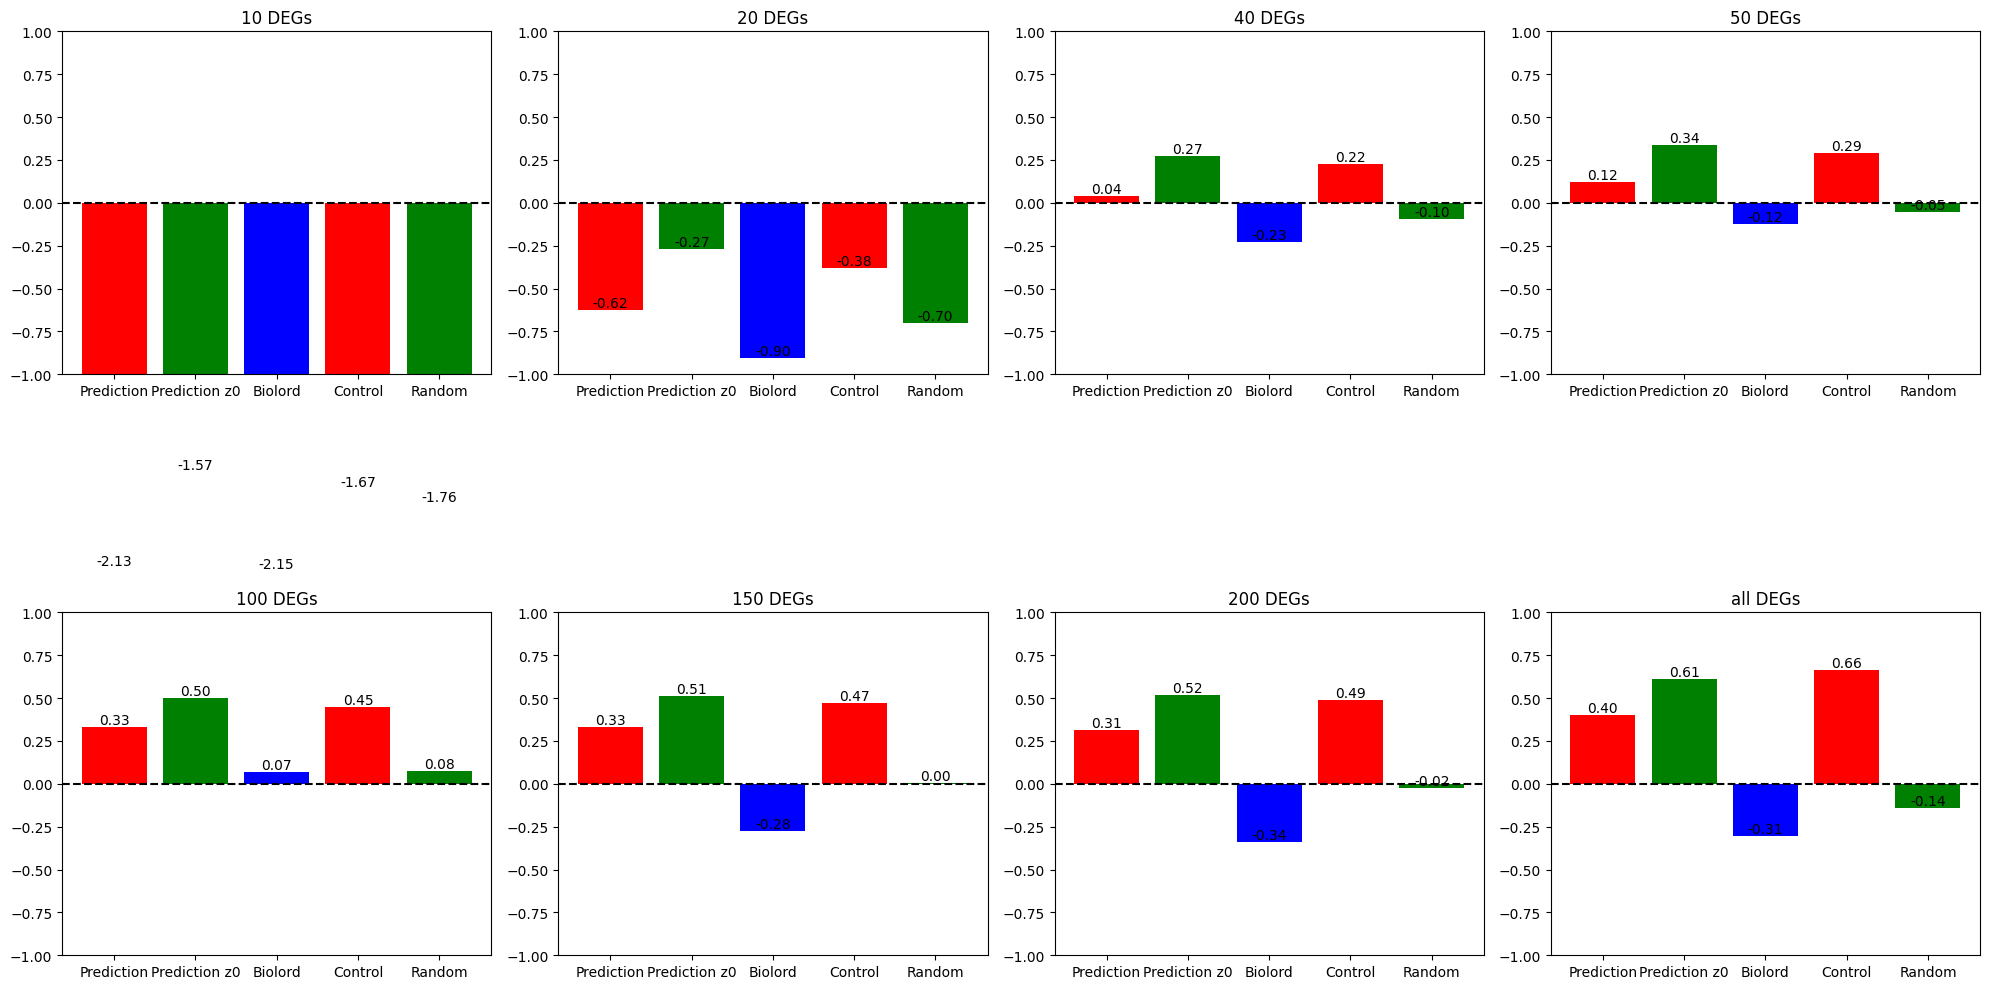

In [76]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i in range(n_rows):
    row = df.iloc[i]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns)  # Setting x-axis labels
    ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Displaying the plot

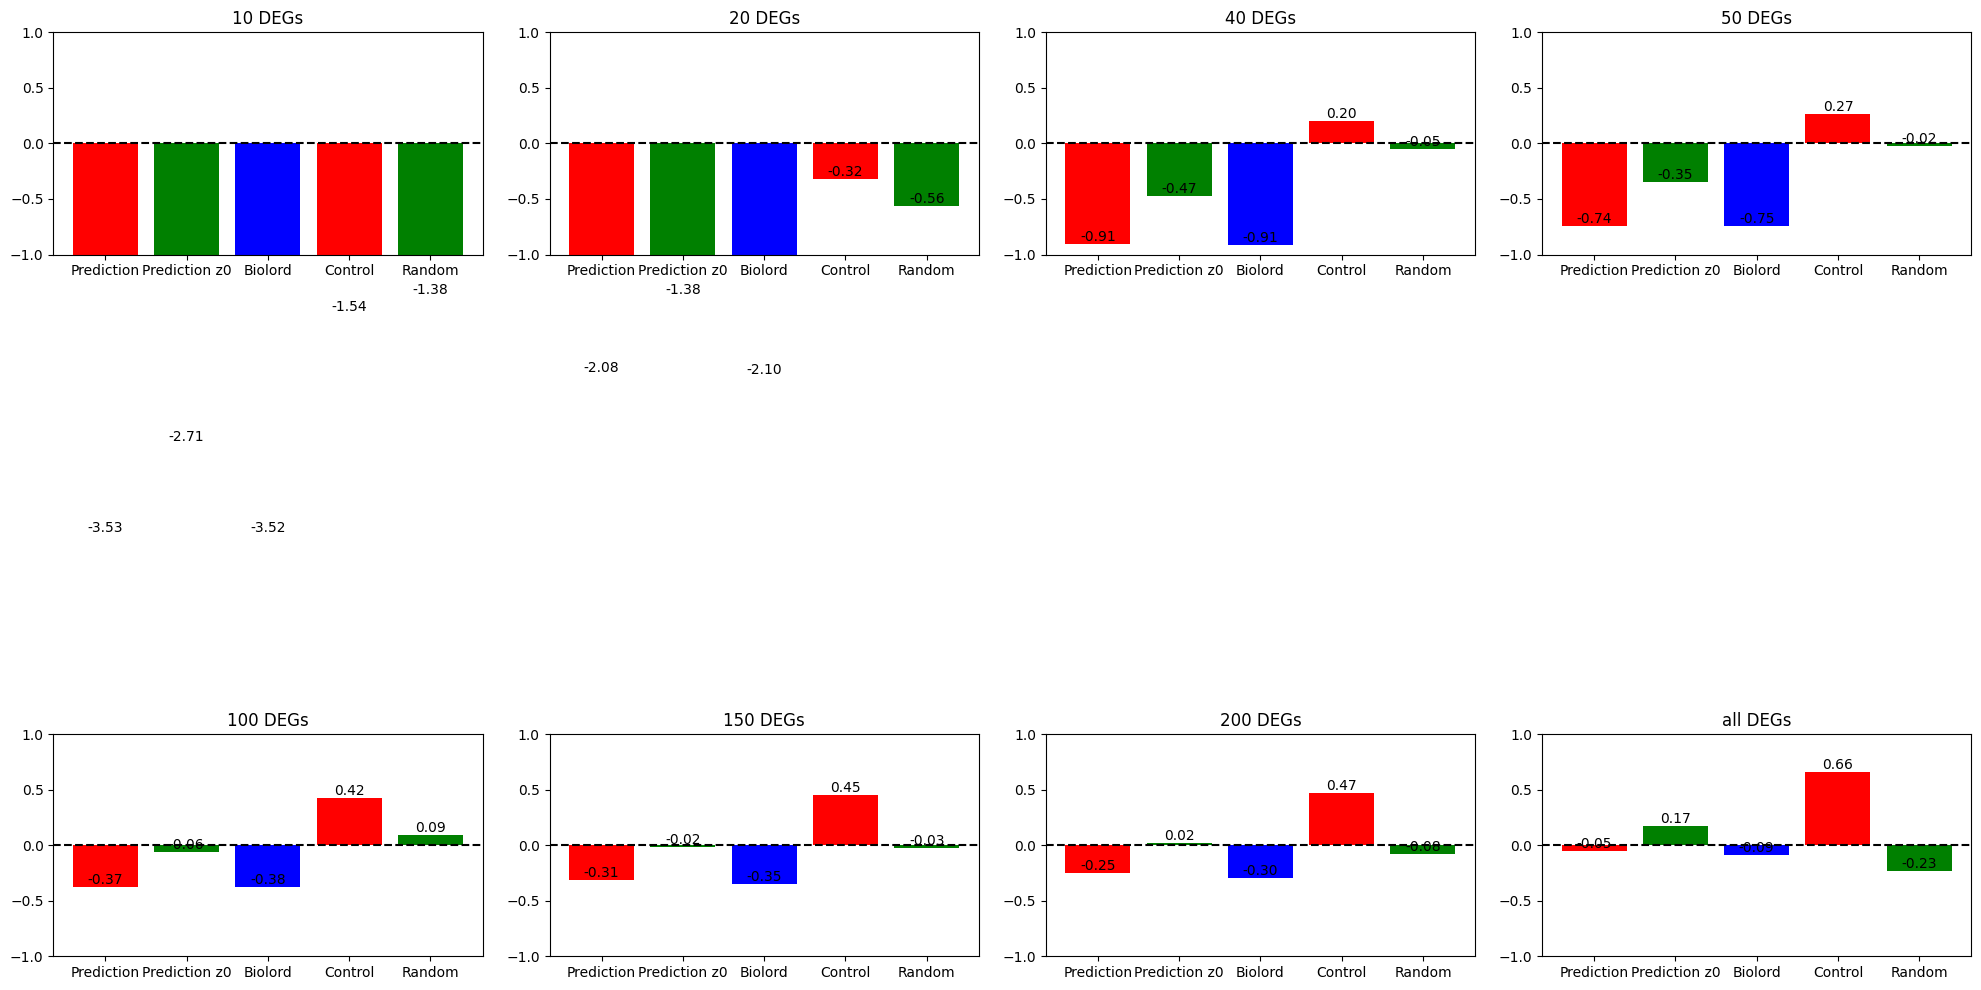

In [77]:
n_rows = r2_var_results.shape[0]
df = r2_var_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i in range(n_rows):
    row = df.iloc[i]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns)  # Setting x-axis labels
    ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Displaying the plot

In [123]:
deg_list

['ENSG00000155307',
 'ENSG00000230876',
 'ENSG00000172673',
 'ENSG00000253300',
 'ENSG00000205542',
 'ENSG00000165553',
 'ENSG00000168685',
 'ENSG00000198888',
 'ENSG00000168214',
 'ENSG00000241956',
 'ENSG00000059804',
 'ENSG00000186094',
 'ENSG00000075624',
 'ENSG00000228716',
 'ENSG00000122862',
 'ENSG00000198840',
 'ENSG00000115738',
 'ENSG00000133392',
 'ENSG00000105372',
 'ENSG00000198763',
 'ENSG00000166710',
 'ENSG00000133454',
 'ENSG00000198804',
 'ENSG00000258077',
 'ENSG00000135046',
 'ENSG00000154556',
 'ENSG00000137818',
 'ENSG00000112232',
 'ENSG00000108107',
 'ENSG00000118849',
 'ENSG00000090104',
 'ENSG00000057294',
 'ENSG00000142937',
 'ENSG00000196482',
 'ENSG00000132965',
 'ENSG00000169306',
 'ENSG00000142541',
 'ENSG00000112530',
 'ENSG00000140988',
 'ENSG00000109472',
 'ENSG00000169442',
 'ENSG00000118997',
 'ENSG00000057657',
 'ENSG00000182601',
 'ENSG00000167526',
 'ENSG00000182256',
 'ENSG00000149273',
 'ENSG00000092969',
 'ENSG00000162511',
 'ENSG00000112936',


In [27]:
today='2024-04-16'